# Descripción del proyecto

La cadena de gimnasios Model Fitness está desarrollando una estrategia de interacción con clientes basada en datos analíticos.

Uno de los problemas más comunes que enfrentan los gimnasios y otros servicios es la pérdida de clientes. ¿Cómo descubres si un/a cliente ya no está contigo? Puedes calcular la pérdida en función de las personas que se deshacen de sus cuentas o no renuevan sus contratos. Sin embargo, a veces no es obvio que un/a cliente se haya ido: puede que se vaya de puntillas.

Los indicadores de pérdida varían de un campo a otro. Si un usuario o una usuaria compra en una tienda en línea con poca frecuencia, pero con regularidad, no se puede decir que ha huido. Pero si durante dos semanas no ha abierto un canal que se actualiza a diario, es motivo de preocupación: es posible que tu seguidor o seguidor/a se haya aburrido y te haya abandonado.

En el caso de un gimnasio, tiene sentido decir que un/a cliente se ha ido si no viene durante un mes. Por supuesto, es posible que estén en Cancún y retomen sus visitas cuando regresen, pero ese no es un caso típico. Por lo general, si un/a cliente se une, viene varias veces y luego desaparece, es poco probable que regrese.

Con el fin de combatir la cancelación, Model Fitness ha digitalizado varios de sus perfiles de clientes. Tu tarea consiste en analizarlos y elaborar una estrategia de retención de clientes.

Tienes que:

* Aprender a predecir la probabilidad de pérdida (para el próximo mes) para cada cliente.
* Elaborar retratos de usuarios típicos: selecciona los grupos más destacados y describe sus características principales.
* Analizar los factores que más impactan la pérdida.
* Sacar conclusiones básicas y elaborar recomendaciones para mejorar la atención al cliente:
    * Identificar a los grupos objetivo;
    * Sugerir medidas para reducir la rotación;
    * Describir cualquier otro patrón que observes con respecto a la interacción con los clientes.

# Importar librerías:

In [1]:
# Se cargan todas las librerías que se puedan usar:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

# Paso 1: cargar el archivo con los datos:

Model Fitness te aportó archivos CSV que contienen los datos sobre la cancelación de un mes en concreto e información del mes que lo precedía. El dataset incluye los siguientes campos:

* 'Churn' — la cancelación para el mes en cuestión

Campos de dataset actuales:
Datos del usuario del mes anterior

* 'gender'.

* 'Near_Location' — si el/la usuario/a vive o trabaja en el vecindario donde se encuentra el gimnasio.

* 'Partner' — si el/la usuario/a trabaja en una compañía asociada (el gimnasio tiene empresas asociadas cuyos empleados obtienen descuentos; en esos casos el gimnasio almacena información sobre los empleadores de los clientes).

* Promo_friends — si el/la usuario/a originalmente se inscribió mediante una oferta “trae a un/a amigo/a” (se utilizó el código promocional de un/a amigo/a cuando pagaron el primer abono).

* 'Phone' — si el/la usuario/a aportó el número de teléfono.

* 'Age'.

* 'Lifetime' — el tiempo (en meses) desde que el/la usuario/a llegó por primera vez al gimnasio.

Datos del registro de visitas y compras y datos sobre el estado actual de la membresía:

* 'Contract_period' — 1 mes, 3 meses, 6 meses o 1 año.

* 'Month_to_end_contract' — los meses que faltan hasta que expire el contrato.

* 'Group_visits' — si el/la usuario/a participa en sesiones grupales.

* 'Avg_class_frequency_total' — frecuencia media de visitas por semana a lo largo de la vida del cliente.

* 'Avg_class_frequency_current_month' — frecuencia media de visitas por semana durante el mes en curso.

* 'Avg_additional_charges_total' — cantidad total de dinero gastado en otros servicios del gimnasio: cafetería, productos deportivos, cosméticos, masajes, etc.

In [2]:
# Se cargan los datos y se almacenan en la variable df:
df = pd.read_csv('/datasets/gym_churn_us.csv')

# Paso 2: Análisis exploratorio de datos (EDA)

## Información general de los datos:

In [3]:
print('Información general de la base de datos:\n')
df.info()

Información general de la base de datos:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_freq

**Conclusión:**

* Se tiene un total de 4000 registros con 14 columnas.

* Hay algunas columnas cuyos nombres tienen mayúsculas.

* Según el info no hay valores ausentes.

* Se observa que el tipo de datos de cada columna es el correcto.

## Corregir nombres de la clolumnas:

In [4]:
# Se cambian a minúsculas los nombres de todas las columnas:
df.columns = df.columns.str.lower()

# Se verifica que se hayan cambiado a minúsculas debidamente los nombres de las columnas:
print('Los nuevos nombres de las columnas quedan registrados de la siguiente forma:\n')
df.info()

Los nuevos nombres de las columnas quedan registrados de la siguiente forma:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 no

**Conclusión:**

* Se han cambiado a minúsculas los nombres de todas las columnas.

* Se ha comprobado que efectivamente los nombres de las columnas están en minúsculas.

## Determinar la presencia de valores ausentes:

In [5]:
# Se cuenta la cantidad de valores ausentes para prevenir que hayan ocurrido fallas en el método info:
print('La cantidad de valores ausentes por columna es:\n')
df.isna().sum()

La cantidad de valores ausentes por columna es:



gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

**Conclusión:** Se ha comprobado que no hay valores ausentes en las columnas.

## Determinar la presencia de filas duplicadas:

In [6]:
# Se cuenta la cantidad de filas totalmente duplicadas.
print('La cantidad de filas totalmente duplicadas es:', df.duplicated().sum(),'.')

La cantidad de filas totalmente duplicadas es: 0 .


In [7]:
# Se muestran las filas totalmente duplicadas:
print('Filas totalmente duplicadas:\n')
df[df.duplicated()]

Filas totalmente duplicadas:



,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn


**Conclusión:** Se comprobó que no existen filas totalmente duplicadas.

## Análisis descriptivo de los datos:

In [8]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Conclusión:**

* La proporción de clientes por género está equilibrada (característica binaria) con una media de 51% y una desviación estándar del 50%.

* El 85% de los clientes viven cerca del gimnasio (característica binaria) con una desviación estándar del 36%.

* El 49% de los clientes trabaja en una compañia afiliada al gimnasio (característica binaria) con una desviacoón estándar del 50%.

* El 31% de los clientes se inscribió mediante una oferta (característica binaria) con una desviación estándar del 46%.

* El 90% de los clientes aportó el número de teléfono (característica binaria) con una desviación estándar del 29%.

* La media del lapso de contratación es de 4.68 meses (característica continua) con una desviación estándar de 4.55 meses.

* El 41% de los clientes partiicipa en sesiones grupales (característica binaria) con una desviación estándar del 49%.

* La media de la edad de los clientes es de 29.18 años (característica continua) con ua desviación estándar de 3.26 años.

* La cantidad total de dinero gastado en otros servicios por los clientes es de USD 146.94 en promedio (característica continua) con una desviación estándar de USD 96.36.

* La media del tiempo que resta para culminar el contrato es de 4.32 meses (característica continua) con nuna desviación estándar de 4.19 meses.

* La media del tiempo desde que llegó cada cliente al gimnasio hasta el momento del registro de los datos es de 3.72 meses (cararcterística continua) con una desviación estándar de 3.75 meses.

* La frecuencia media de visitas para los clientes es de 1,76 visitas por semana (característica continua) con una desviación estándar de 0.98 visitas por semana.

* El 27% de los clientes han cancelado el contrato (característica binaria) con una desviación estándar del 44%.

* Hay un total de 7 característica binarias de las cuales una es la variable objetivo (churn) y un total de 6 características continuas.

## Valores medios para cada caraterística por cada grupo (clientes que no cancelan el contrato y clientes que si lo cancelan):

In [9]:
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


**Conclusiones:**

* El porcentaje de clientes para cada **género** es muy **similar** para el grupo de personas que cancelan que para el grupo de personas que continúan en el gimnasio, siendo en ambos casos las proporciones del **51** y **49%** para cada género en ambos grupos, razón por la cual **no** se puede inferir que el género del cliente **influya** en la decisión de cancelación.

* El porcentaje de clientes que **viven cerca del gimnasio** es un poco **mayor** en el grupo de **clientes que continúan en el gimnasio** que en el grupo de los que **cancelan** siendo éste porcentaje del **87** y el **77%** respectivamente, tomando en cosnideración dicha diferencia, se puede inferir que esta característica puede **influir** en la decisión de **cancelación** por parte del cliente.

* El porcentaje de clientes que **trabajan en empresas afiliadas** al gimnasio y que continúan es del **53%**, mientras que en el caso de las que las personas que cancelqan es del **35%** lo cual es una diferencia importante y que podía considerarse que **afecta** en la decisión del cliente de **cancelar**.

* El porcentaje de clientes que llegaron al gimnasio por la promoción **"trae a un amigo"** es del **35%** en el grupo de clientes que se quedan en el gimnasio, mientras que en el caso de los que cancelaron éste porcentaje es del **18%** por lo cual se puede deducir que esta característica **influye** en la decisión de **cancelación** de los clientes.

* La proporción de personas **aportaron un número de teléfono** en el momento del registro es del **90%** para ambos grupos, razón por la cual **no** se espera que esta característica **incida** en la **cancelación** de los clientes.

* El promedio de **meses del contrato** es **más alto** en el grupo de personas que **se quedan** que en el grupo de las personas que **cancelan**, siendo éste promedio de **5.75** y **1.73** meses respectivamente razón por la cual se infiere que esta característica **influye** en la decisión de **cancelación** del cliente.

* El **46%** de los clientes que continúan en el gimnasio participan de **sesiones grupales de entrenamiento**, mientras que el **27%** de los clientes que cancelan participan de sesiones grupales, razón por la cual se puede esperar que esta característica **incida** en la decisión de **cancelar** el cliente.

* La **edad** promedio de los clientes que **continúan** es de **29.98 años**, mientras que la edad promedio de las personas que **cancelan** es de **26.99 años**, por lo que se puede considerar que esta característica puede **afectar** la decisión de **cancelación**.

* El **gasto en otros servicios del gimnasio** promedio es de **USD 158.45** para el grupo de los clientes que **continúan**, mientras que en los clientes que **cancelan**, ese promedio es de **USD 115.08** por lo que se deduce que esta característica **incide** en la decisión de **cancelar**.

* El **tiempo que resta para finalizar el contrato** es de **5.28 meses** en promedio para los clientes que **continúan** y de **1.66 meses** en promedio para los clientes que **cancelan**, por lo que se observa que esta variable puede **afectar** en la decisión de **cancelar** por parte del cliente.

* El **tiempo que ha transcurrido desde que el cliente fué al gimnasio por primera vez** es de **4.71 meses** en promedio para los clientes que **continúan** en el gimnasio, mientras que para los clientes que **cancelan** es de **0.99 meses** en promedio, por lo cual se puede apreciar una fuerte **relación** entre la **antigüedad** de un cliente y la probabilidad de que éste **cancele**.

* La **frecuencia de visitas promedio por semana a lo largo de la vida del cliente** al gimnasio por prate de los clientes que **continúan** es de **2.02 visitas por semana** en promedio; mientras que para los clientes que **cancelan**, éste valor es de **1.48 visitas semanales** en promedio, por lo que se puede considerar que esta característica **incide** en la **cancelación** de los clientes.

* La **frecuencia promedio de visitas por semana en el último mes** para los clientes que **continúan** se mantiene aproximadamente **constante** respecto a la **frecuencia promedio para todo el tiempo de vida del cliente**, mientras que la **frecuencia promedio de visitas semanales para el último mes disminuye** respecto al **promedio de todo el tiempo de vida del cliente** en el grupo de personas que **cancelan**, por lo que se puede concluir que esta variable puede ayudar a **pedecir** la **cancelación** de los clientes.

### Gráfico de barras para observar la proporción de clientes que no cancelaron el contrato y los  que si lo cancelaron:

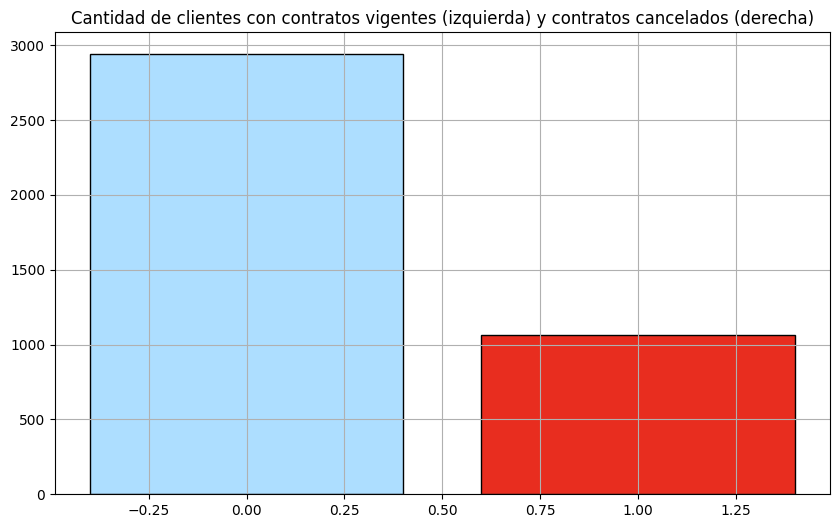

In [10]:
conteo = df.churn.value_counts()

cols = ['#addeff', '#e82d1f']

plt.figure(figsize = (10, 6))
plt.bar(conteo.index, conteo.values,  color=cols, edgecolor='black')
plt.title('Cantidad de clientes con contratos vigentes (izquierda) y contratos cancelados (derecha)')
plt.grid(True)
plt.show()

In [11]:
print('La cantidad total de clientes con contrato vigente y contrato cancelado es:')
conteo

La cantidad total de clientes con contrato vigente y contrato cancelado es:


0    2939
1    1061
Name: churn, dtype: int64

**Conclusión:**

* Un poco más de 2900 usuarios correspoden a clientes cuyo contrato aún está vigente.

* Un poco más de 1000 usuarios corresponden a clientes cuyo contrato ya se canceló. 

### Gráficos de barras para  observar la relación entre el lapso de duración del contrato y  las caraterísticas binarias de los clientes:

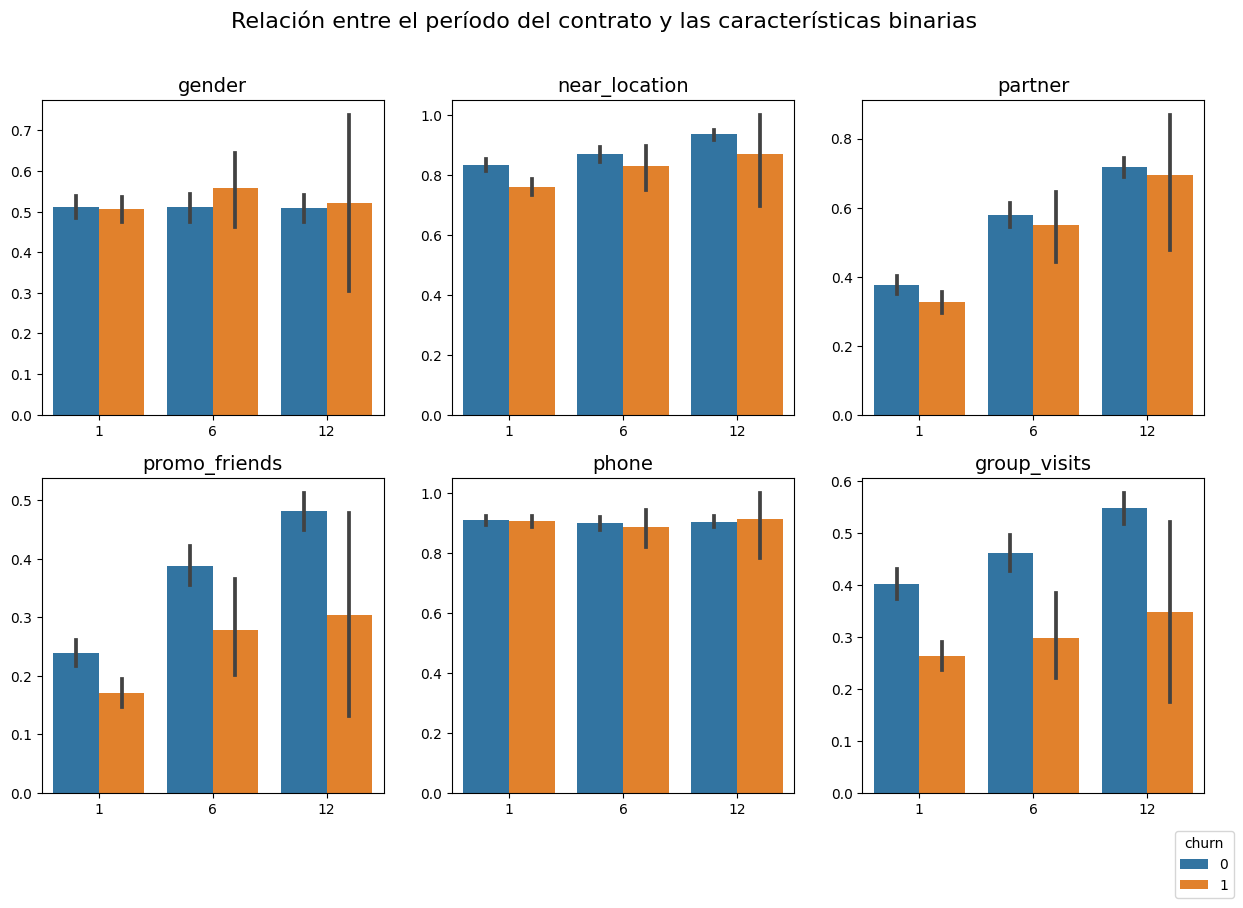

In [12]:
# Se seleccionan las características binarias de los clientes:
columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

# Se distribuyen las gráficas de las características binarias:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,9))

# Bucle para generar cada gráfica:
for i, ax in enumerate(axs.flat):
    if i < len(columns):
        sns.barplot(x='contract_period', y=columns[i], data=df, hue='churn', ax=ax)
        ax.legend([], [], frameon=False)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(f'{columns[i]}', fontsize=14)
    else:
        ax.axis('off')

# Obtener los identificadores y etiquetas de la leyenda:
handles, labels = plt.gca().get_legend_handles_labels()

# Personalizar la leyenda:
plt.legend(handles, labels, title='churn', loc='upper center', bbox_to_anchor=(1, -0.1), frameon=True)

fig.suptitle('Relación entre el período del contrato y las características binarias', fontsize=16)
fig.subplots_adjust(top=0.88)
plt.show()

**Conclusión:**

* Al comparar las caraterísticas binarias de todos los clientes de forma general, solo se observan diferencias en las caraterísticas **'promo_friends'** y **'group_visits'**.

* La **mayor proporción de clientes que cancelaron** corresponde a clientes que **no llegaron por algún descuento promocional de un amigo** y esto es cierto para los clientes con **lapsos de contrato de 6 meses o menos**.

* En cuanto a la caraterística **'group_visits'** se puede concluir que el mayor porcentaje de clientes que cancelaron, corresponde a **clientes que no participaban de entrenamientos grupales** y cuyos contratos eran de **menos de 6 meses**.

* En las otras caraterísticas binarias no se observó diferencias significativas entre los grupos de personas que cancelan y los de personas que se quedan.

* En resumen, las diferencias entre los clientes que cancelan y los que se quedan no son lo suficientemente marcadas como para poder predecir con seguridad o con un alto porcentaje de atino, que los clientes cancelen o se vayan.

### Gráficos de barras para  observar la relación entre el lapso de duración del contrato y  las caraterísticas continuas de los clientes:

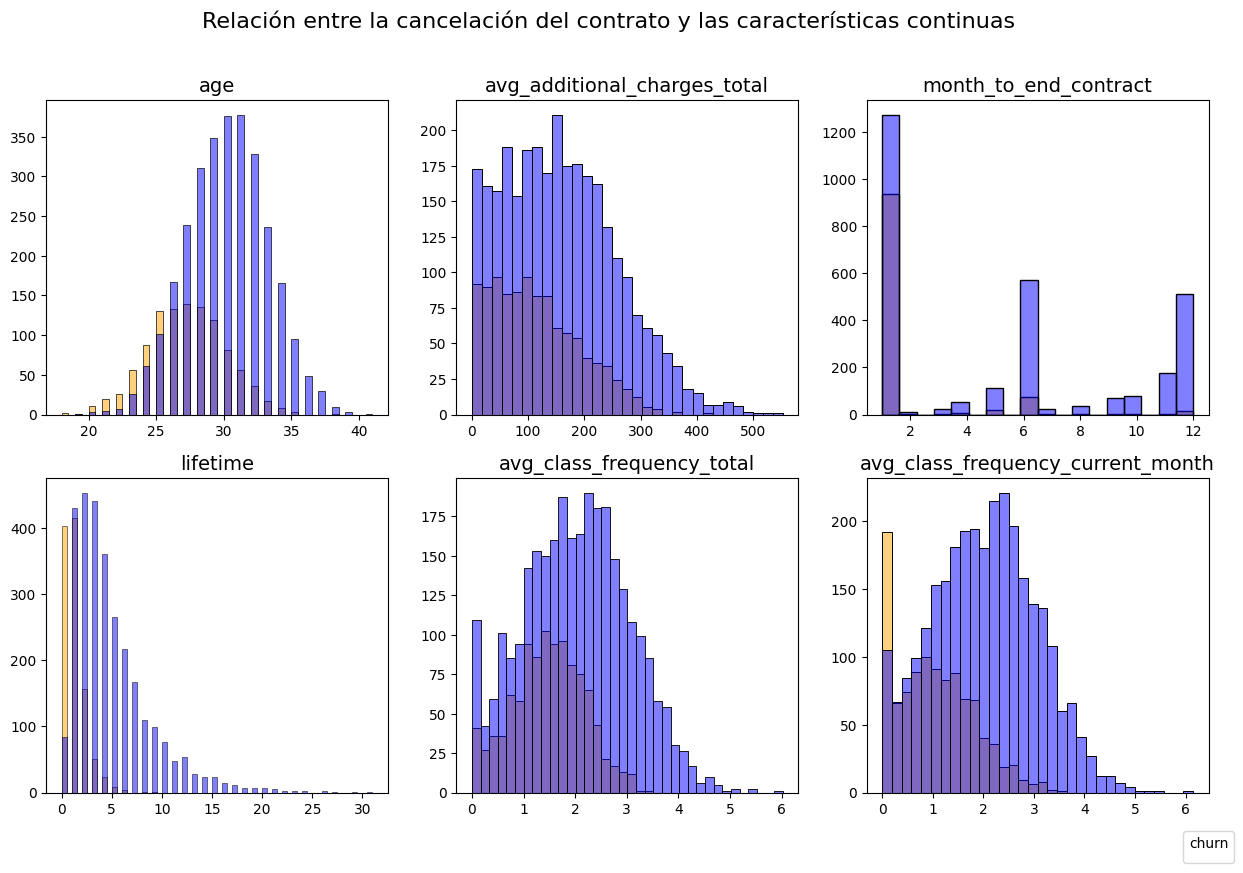

In [13]:
# Se seleccionan las características continuas de los clientes:
columns = ['age', 'avg_additional_charges_total', 'month_to_end_contract',
           'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

# Se asigna el color de las barras:
cols = ['blue', 'orange']

# Se crean los gráficos:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,9))
for i, ax in enumerate(axs.flat):
    if i < len(columns):
        sns.histplot(x=columns[i], data=df, hue='churn', palette=cols, ax=ax)
        ax.legend([], [], frameon=False)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(f'{columns[i]}', fontsize=14)
    else:
        ax.axis('off')

# Obtener los identificadores y etiquetas de la leyenda:
handles, labels = plt.gca().get_legend_handles_labels()

# Personalizar la leyenda:
plt.legend(handles, labels, title='churn', loc='upper center', bbox_to_anchor=(1, -0.1), frameon=True)

# Se asigna el título del gráfico:
fig.suptitle('Relación entre la cancelación del contrato y las características continuas', fontsize=16)
fig.subplots_adjust(top=0.88)

# Se muestran los gráficos:
plt.show()

**Conclusiones:**

* La media de edad de los clientes es ligeramente menor en los clientes que cancelan que en loc clientes que se quedan; además, lo clientes de más de 33 años son los que menos probabilidad tienen de cancelar.

* Los clientes que gastan en el mes más de **USD 300** en otros servicios del gimnasio tienen menos probabilidad de cancelar.

* Para la característica **'month_to_end_contract'** lo más común y casi único es que los clientes que cancelan les falta un mes para finalizar el contrato, pero no permite predecir ya que no todos los clientes a los que les queda un mes para finalizar el contrato lo cancelan.

* Casi todos los clientes que cancelan tienen **menos de 6 meses** de haber acudido al gimnasio **por primera vez**.

* La gran mayoría de clientes que canelan acuden al gimnasio **menos de 3 veces a la semana en promedio**.

* Al observar todas estas características y su distribución, no es del todo preciso realizar predicciones de cancelación con estos gráficos o valores, ya que así como se tienen clientes que cancelan en ciertos rangos de cada caraterística, del mismo modo los clientes que no cancelan comparten ese mismo rango de valores de las características, razón por la cual los modelos de pronósticos o predicciones pueden ser muy útiles para hallar vinculaciones entre los valores que un humano no podría identificar debido al gran volumne de datos y características involucradas.

### Mapa de calor de la correlación entre las características:

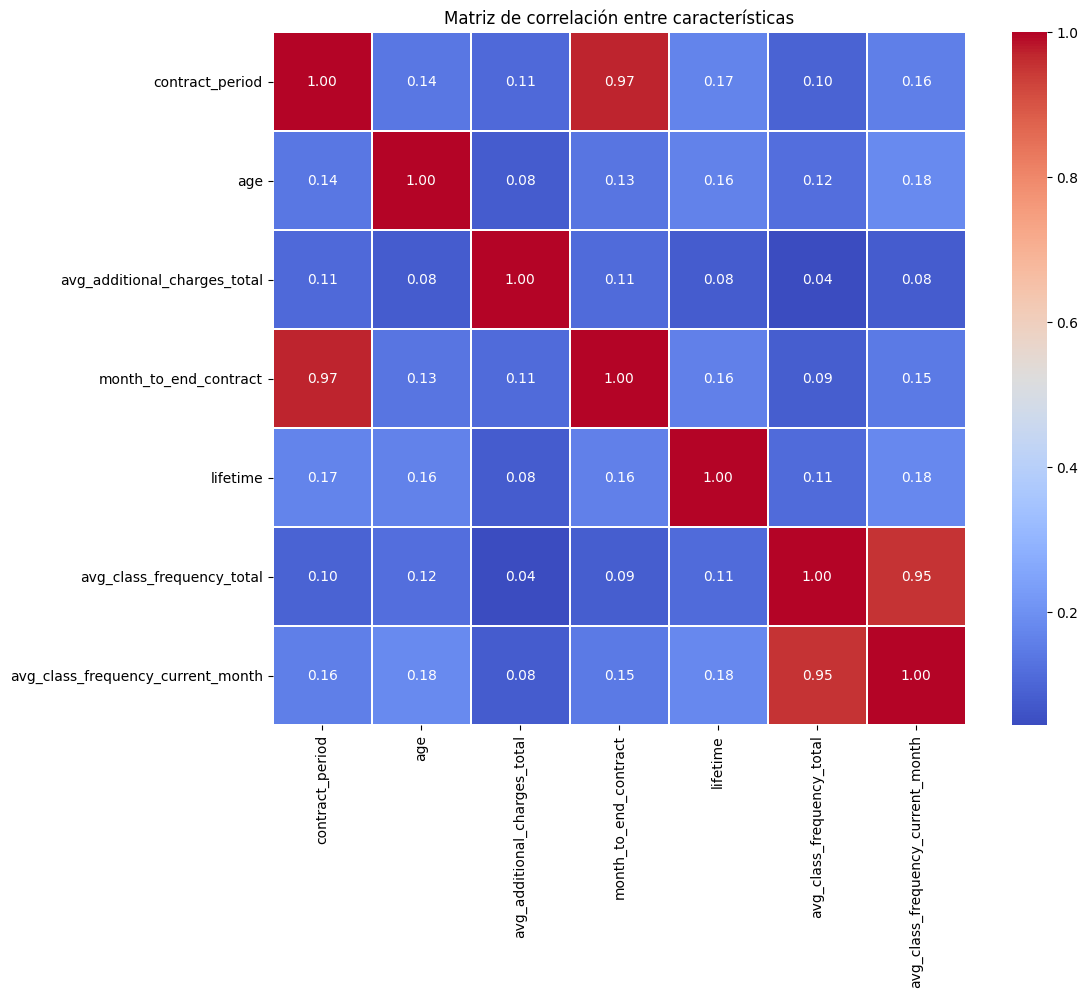

In [14]:
# Se seleccionan los nombres de las características continuas:
quant_cols = ['contract_period', 'age', 'avg_additional_charges_total',
              'month_to_end_contract', 'lifetime', 'avg_class_frequency_total',
              'avg_class_frequency_current_month']

# Se separan las columnas con las características continuas:
gym_churn_quant = df[quant_cols]

# Se obtiene la matriz de correlación de las variables:
cm = gym_churn_quant.corr()

# Se asigna el tamaño de la figura:
plt.figure(figsize=(12,9))

# Se asigna título al gráfico:
plt.title('Matriz de correlación entre características')

# Se configura el mapa de calor:
sns.heatmap(cm, fmt='.2f', annot=True, square=True, linewidths=1, linecolor='white', cmap='coolwarm')

# Se muestra el mapa de calor:
plt.show(block=False)

**Conclusión:**

* La frecuencia media de visitas semanales de los clientes en el mes en curso y el promedio de visitas semanales a lo largo de la vida del cliente se mentienen casi iguales por lo que el R cuadrado es casi 1 por lo que trabajar con una u otra característica es casi lo mismo.

* Del mismo modo ocurre con lapso de duración del contrato y los meses para finalizar el contrato, aunque no necesariamente un cliente va a esperarse a que se cumpla el tiempo de contrato para cancelar sino que éste puede cancelar antes de que se cumpla dicho tiempo.

* El resto de variables tienen una correclación muy baja entre ellas.

# Paso 3: Construir un modelo para predecir la cancelación de usuarios:

Crear un modelo de clasificación binaria para clientes donde la característica objetivo es la marcha del usuario o la usuaria el mes siguiente.

## Dividir los datos en conjuntos de entrenamiento y validación utilizando la función train_test_split().

In [15]:
# Se obtienen los valores "X" (variables independientes):
X = df.drop('churn', axis = 1)
# Se obtienen los valores "y" (variable objetivo):
y = df['churn']

# Dividir los datos en entrenamiento y prueba:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Entrena el modelo en el set de entrenamiento con dos métodos:

* Regresión logística.

* Bosque aleatorio.

### Entrenar el modelo con los datos dados empleando el método de Regresión Logística:

#### Se cambia la escala de los datos de entrenamiento y de prueba:

In [16]:
# Se cambia la escala de los valores de entrenamiento y prueba:
scaler = StandardScaler()

# Se transforma la escala de los valores de entrenamiento del modelo (las variables binarias no sufren ninguna modificación
# al realizar esta transformación):
X_train_st = scaler.fit_transform(X_train) 

# Se transforma la escala de los valores de prueba
X_test_st = scaler.transform(X_test)

#### Se selecciona el modelo para el entrenamiento:

In [18]:
# Se selecciona el modelo de entrenamiento y se fija el estado aleatorio en 0 y considerando las clases balanceadas:
model_lr = LogisticRegression(random_state = 0, class_weight = 'balanced')

# Se entrena el modelo dados los valores X_train_st y y_train
model_lr.fit(X_train_st, y_train)

LogisticRegression(class_weight='balanced', random_state=0)

#### Se realiza el pronóstico:

In [38]:
# Se realiza el pronóstico con los valores de prueba estandarizados:
pred_lr = model_lr.predict(X_test_st)

# Se muestran las primeras 5 filas de predicciones:
print('La primeras 5 predicciones del modelo de Regresión Logística, son:\n')
pred_lr[:5]

La primeras 5 predicciones del modelo de Regresión Logística, son:



array([0, 1, 1, 1, 0])

#### Probabilidades de cancelación de cada cliente:

In [39]:
# Se realiza el cálculo de probabilidades de pertenecer a la clase:
pred_prob_lr = model_lr.predict_proba(X_test_st)[:, 1]

# Se muestran las primeras 5 filas de las probabilidades de que cada cliente cancele:
print('La probabilidades de que cada uno de los primeros clientes cancele según el modelo de Regresión Logística, son:\n')
pred_prob_lr[:5]

La probabilidades de que cada uno de los primeros clientes cancele según el modelo de Regresión Logística, son:



array([0.00351837, 0.99088582, 0.69028176, 0.97514174, 0.07095339])

#### Cancelación real y predición de cancelación:

In [21]:
# Se comparan los valores de prueba 'y_test' y los del pronóstico 'y_pred'
predicciones_lr = pd.DataFrame({'y_real': y_test.values, 'y_pred': pred_lr}, index = y_test.index)

# Se muestran los valores reales de cancelación de los datos de prueba y los de la predicción:
print('Valores reales de la cancelación de los datos de prueba junto con los de la predicción con el modelo de',
      'Regresión Logística:\n')
predicciones_lr

,y_real,y_pred
2230,0,0
668,1,1
3616,0,1
2363,1,1
142,0,0
...,...,...
1118,1,1
3572,0,0
2482,0,0
643,0,0


### Entrenar el modelo con los datos dados empleando el método de Bosque Aleatorio:

#### Se selecciona el modelo para el entrenamiento:

In [23]:
# Se selecciona el modelo de entrenamiento Random Forest seleccionando un total de 50 árboles y de 10 ramas, esto con el fin
# de tener alta precisión pero sin sobre cargar el equipo.
model_rf = RandomForestClassifier(n_estimators = 50, max_depth = 10, random_state = 0)

# Se entrena el modelo dados los valores X_train_st y y_train
model_rf.fit(X_train_st, y_train)

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=0)

#### Se realiza el pronóstico:

In [40]:
# Se realiza el pronóstico con los valores de prueba estandarizados:
pred_rf = model_rf.predict(X_test_st)

# Se muestran las primeras 5 filas de predicciones:
print('La primeras 5 predicciones del modelo de Bsoque Aleatorio, son:\n')
pred_rf[:5]

La primeras 5 predicciones del modelo de Bsoque Aleatorio, son:



array([0, 1, 0, 1, 0])

#### Probabilidades de cancelación de cada cliente:

In [41]:
# Se realiza el cálculo de probabilidades de pertenecer a la clase:
pred_prob_rf = model_rf.predict_proba(X_test_st)[:, 1]

# Se muestran las primeras 5 filas de las probabilidades de que cada cliente cancele:
print('La probabilidades de que cada uno de los primeros clientes cancele según el modelo de Bosque Aleatorio, son:\n')
pred_prob_rf[:5]

La probabilidades de que cada uno de los primeros clientes cancele según el modelo de Bosque Aleatorio, son:



array([0.02042553, 0.95240819, 0.20840476, 0.88075128, 0.06333333])

#### Cancelación real y predicción de cancelación:

In [26]:
# Se comparan los valores de prueba 'y_test' y los del pronóstico 'y_pred'
predicciones_rf = pd.DataFrame({'y_real': y_test.values, 'y_pred': pred_rf}, index = y_test.index)

# Se muestran los valores reales de cancelación de los datos de prueba y los de la predicción:
print('Valores reales de la cancelación de los datos de prueba junto con los de la predicción con el modelo de',
      'Bosque Aleatorio:\n')
predicciones_rf

,y_real,y_pred
2230,0,0
668,1,1
3616,0,0
2363,1,1
142,0,0
...,...,...
1118,1,1
3572,0,0
2482,0,0
643,0,0


### Unión de los pronósticos de ambos modelos:

In [42]:
# Se unen los valores de predicciones de ambos modelos junto con los valores reales:

# Se crea una nueva variables en la que se guardan los valores de predicción de Regresión Logística:
predicciones = predicciones_lr

# Se cambia el nombre de la columna 'y_pred' por 'y_lr':
predicciones.rename(columns = {'y_pred': 'pred_lr'}, inplace = True)

# Se agrega la columna de predicciones del modelo de Bosque Aleatorio:
predicciones['pred_rf'] = predicciones_rf['y_pred']

# Se muestran las predicciones de ambos modelos junto con las cancelaciones reales:
print('Las cancelaciones reales y las predichas por los modelos de Regresión Logística y Bosque Aleatorio, son:\n')
predicciones

Las cancelaciones reales y las predichas por los modelos de Regresión Logística y Bosque Aleatorio, son:



,y_real,pred_lr,pred_rf
2230,0,0,0
668,1,1,1
3616,0,1,0
2363,1,1,1
142,0,0,0
...,...,...,...
1118,1,1,1
3572,0,0,0
2482,0,0,0
643,0,0,0


### Comparar las métricas para los de los modelos de aprendizaje utilizados:

In [28]:
# Valor medio de la variable objetivo en el conjunto de prueba:
print('La media de los valores de prueba es: {:.2f}'.format(predicciones['y_real'].mean()))
print('La media del pronostico empleando el método de regresión logística es: {:.2f}'.format(predicciones['pred_lr'].mean()))
print('La media del pronostico empleando el método de bosque aleatorio es: {:.2f}'.format(predicciones['pred_rf'].mean()),'\n')

# Se imprimen las métricas principales:
print('Métricas para el pronóstico realizado con el método de regresión logística:')
print('Exactitud: {:.2f}'.format(accuracy_score(predicciones['y_real'], predicciones['pred_lr'])))
print('Precisión: {:.2f}'.format(precision_score(predicciones['y_real'], predicciones['pred_lr'])))
print('Recall: {:.2f}'.format(recall_score(predicciones['y_real'], predicciones['pred_lr'])),'\n')

print('Métricas para el pronóstico realizado con el método de bosque aleatorio:')
print('Exactitud: {:.2f}'.format(accuracy_score(predicciones['y_real'], predicciones['pred_rf'])))
print('Precisión: {:.2f}'.format(precision_score(predicciones['y_real'], predicciones['pred_rf'])))
print('Recall: {:.2f}'.format(recall_score(predicciones['y_real'], predicciones['pred_rf'])))

La media de los valores de prueba es: 0.25
La media del pronostico empleando el método de regresión logística es: 0.29
La media del pronostico empleando el método de bosque aleatorio es: 0.23 

Métricas para el pronóstico realizado con el método de regresión logística:
Exactitud: 0.91
Precisión: 0.77
Recall: 0.91 

Métricas para el pronóstico realizado con el método de bosque aleatorio:
Exactitud: 0.91
Precisión: 0.84
Recall: 0.79


**Conclusiones:**

* El modelo de aprendizaje de **Regresión Logística** ha pronosticado un **29% de cancelaciones**, el modelo de aprendizaje del método **Árbol Aleatorio** pronosticó un **23% de cancelaciones** de los contratos y los **valores de prueba** tuvieron **25% de cancelaciones** de contratos; esto quiere decir que el porcentaje de cancelaciones pronosticado con el método **Regresión Logística** arrojó un valor **4 puntos porcentuales** por encima del valor real mientras que el método de aprendizaje **Bosque Aleatorio** arrojó un valor de **2 puntos porcentuales** por debajo del valor real.

* La **exactitud** (accuracy) de ambos modelos es igual (**91%**), esto quiere decir que el **91%** de los pronósticos se cumplieron en ambos modelos.

* La **precisión** del modelo de **Árbol aleatorio** es de **84%**, siendo esta mayor que la del modelo **Regresión Logística** la cual es del **77%**, esto quiere decir que **de cada 100 personas que los modelos predijeron que cancelarían, realmente cancelaron 84 y 77 clientes para cada modelo respectivamente** .

* Por su parte, la **exhaustividad (recall)** es mayor en el modelo **Regresión Logística** con un valor de **91%**, mientras que el modelo de aprendizaje **Árbol Aelatorio** fué de **79%**; esto es, **de cada 100 personas que cancelaron en los datos de prueba, 91 y 79 fueron predichas por el modelo de Regresión Logística y el de Árbol Aleatorio respectivamente** lo cual es una diferencia bastante grande entre ambos modelos.

* Ambos modelos tienen sus ventajas y sus desventajas, pero el modelo de **Regresión Logística** obtuvo en 2 métricas puntuaciones mayores al 90%, mientras que el modelo de de **Bosque Aleatorio** solo obtubvo en una métrica una puntuación mayor al 90%.

## Paso 4: Crear clústeres de usuarios:

Deja de lado la columna con datos sobre la cancelación e identifica los clústeres de objetos (usuarios).

### Estandarizar los datos:

In [29]:
# estandariza los datos
sc = StandardScaler()
x_sc = sc.fit_transform(X)

### Utiliza la función linkage() para crear una matriz de distancias basada en la matriz de características estandarizada y trazar un dendrograma.

Nota: ¡renderizar el dendrograma puede llevar tiempo! Utiliza el gráfico resultante para estimar el número de clústeres que puedes destacar.

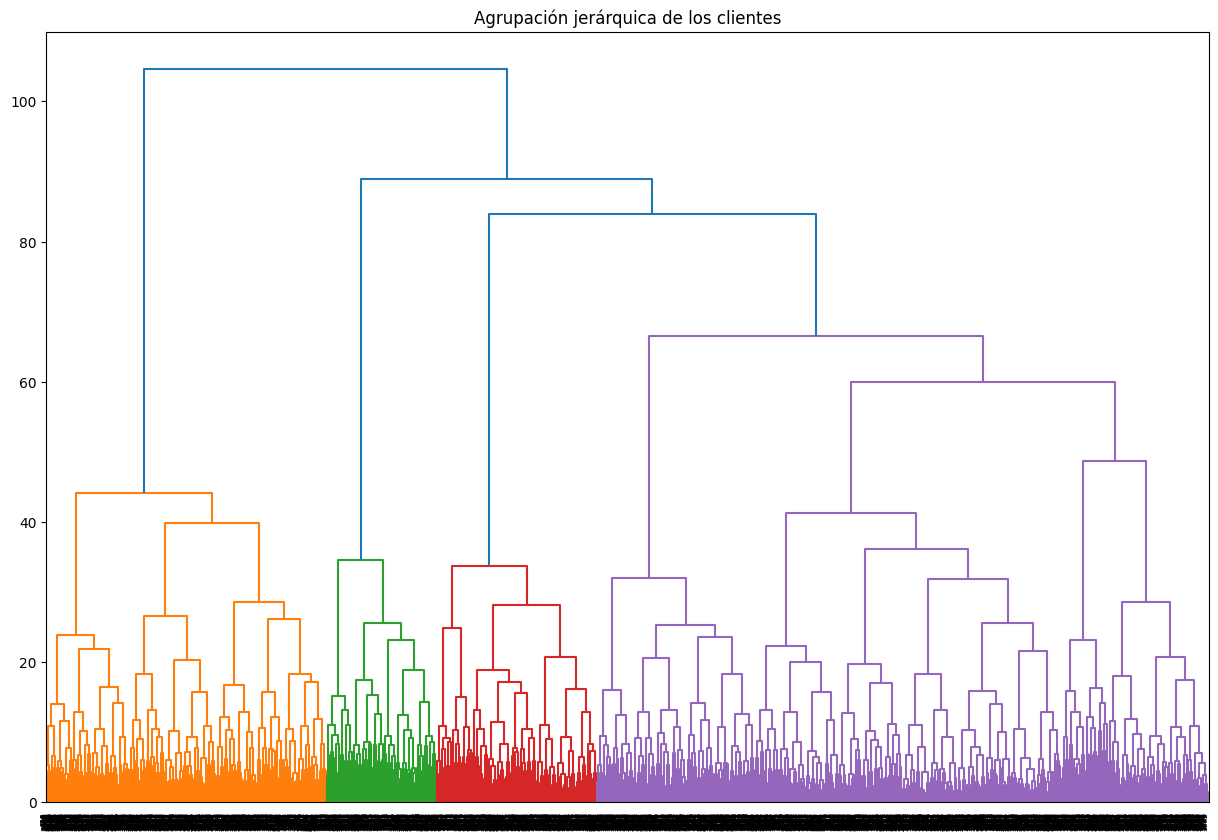

In [30]:
# Se halla la vinculación entre los datos:
linked = linkage(x_sc, method = 'ward')
# La variable linked almacena la tabla con los haces de objetos vinculados.

# Se traza el dendograma para visualizar la vinculación entre los datos:

# Se dimensiona el dendrograma:
plt.figure(figsize=(15, 10))  

# Se pasan los datos para crear el dendrograma:
dendrogram(linked, orientation='top')

# Se asginga el título al dendrograma:
plt.title('Agrupación jerárquica de los clientes')

# Se rotan las etiquetas de los valores del eje "x", aunque como son 800 datos no se verán claramente:
plt.xticks(rotation=90, ha='right')

# Se muestra el dendrograma:
plt.show()

### Entrena el modelo de clustering con el algortimo K-means y predice los clústeres de clientes.

Deja que el número de clústeres sea n=5 (el número óptimo de clústeres sugerido (4) corresponde a los cuatro colores diferentes del gráfico) para que sea más sencillo comparar los resultados con los del resto del estudiantado. Sin embargo, en la vida real, nadie te dará tales pistas, así que tendrás que decidir basándote en el gráfico del paso anterior.

In [31]:
# Se define el modelo k_means con 4 clústeres:
km = KMeans(n_clusters = 4, random_state = 0) # Se han seleccionado 4 clústeres debido a que el dendrograma nos separó 4 grupos 

# Se predicen los clústeres para las observaciones (el algoritmo les asigna un número de 0 a 3)
labels = km.fit_predict(x_sc)

# Almacenar etiquetas de clúster en el campo de nuestro conjunto de datos
df['cluster'] = labels

### Mira los valores medios de característica para los clústeres.¿Hay algo que te llame la atención?

In [43]:
# Se obtienen las estadísticas de los valores medios de las características por clúster

print('Promedio para cada característica por cada cluster:\n')
df.groupby(['cluster']).mean()

Promedio para cada característica por cada cluster:



,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839
1,0.486815,0.759297,0.381339,0.190669,1.0,1.899256,0.292765,28.048005,129.704525,1.805274,2.235294,1.204610,0.951590,0.559838
2,0.544939,0.861873,0.343425,0.205298,1.0,2.403027,0.447493,29.989593,157.358764,2.239357,4.704825,2.724796,2.711132,0.092715
3,0.503711,0.940631,0.777365,0.572356,1.0,10.697588,0.536178,29.912801,161.363032,9.768089,4.730056,1.983884,1.975592,0.029685


**Conclusiones:**

* En los clústeres **0** y **1** las tasas  de cancelación son **26.68** y **55.98%** respectivamente, y en el segundo grupo de clústeres son los cluster **2** y **3** con tasa de cancelación del **9.27** y **2.97%** respectivamente.

* En el primer grupo de clústeres el **'avg_additional_charges_total'** fué de **USD 144.21** y **USD 129,70** para los clústeres **0** y **1** respectivamente, mientras que el segundo grupo de clústeres, la media fué de **USD 157.36** y **USD 161.36** respectivamente.

* Los usuarios del primer clúster tienen un promedio de asistencia (**'avg_class_frequency_current_month'**) inferior a 2 veces por semana en el último mes (**1.72** y **0.95** para el cluster **0** y **1** respectivamente), mientras que los usuarios del segundo grupo de clústeres asiste en promedio más de 2 veces por semana o más (**2.71** y **1.98** para el cluster **2** y **3** respectivamente).

* El promedio de asistencia semanal del último mes (**'avg_class_frequency_current_month'**) disminuye de **1.85** a **1.72** veces por semana respecto al promedio de todo el tiempo de vida del cliente (**'avg_class_frequency_total'**) para el cluster **0**, de **1.20** a **0.95** para los clientes del cluster **1** lo cual representa una reducción significativa si se compara con el otro grupo de clústeres en los cuales las medias de asistencias de los clientes se mantienen casi iguales **2.72** a **2.71** para el cluster **2**, y de **1.98**	a **1.97** para el cluster **3**.

* El promedio de vida de los clientes de los clústeres **0** y **1** son **3.94** y **2.23** meses, mientras que los clientes de los clústeres **2** y **3** tienen un promedio de **4.70** y **4.73** meses de vida como clientes.

### Traza distribuciones de características para los clústeres. ¿Notas algo?

#### Gráficas de las variables binarias:

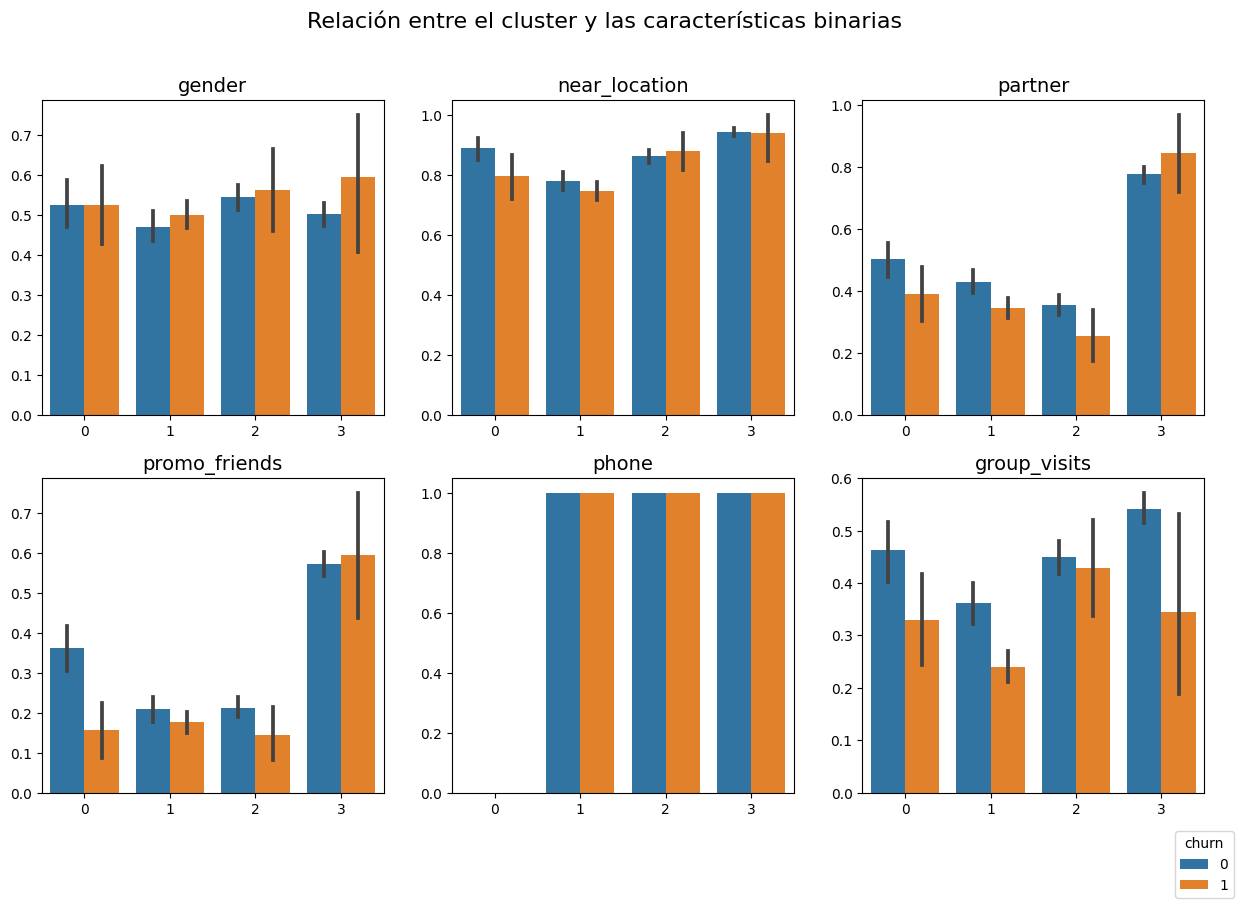

In [33]:
# Se seleccionan las características binarias de los clientes:
columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

# Se distribuyen las gráficas de las características binarias:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,9))

# Bucle para generar cada gráfica:
for i, ax in enumerate(axs.flat):
    if i < len(columns):
        sns.barplot(x='cluster', y=columns[i], data=df, hue='churn', ax=ax)
        ax.legend([], [], frameon=False)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(f'{columns[i]}', fontsize=14)
    else:
        ax.axis('off')

# Obtener los identificadores y etiquetas de la leyenda:
handles, labels = plt.gca().get_legend_handles_labels()

# Personalizar la leyenda:
plt.legend(handles, labels, title='churn', loc='upper center', bbox_to_anchor=(1, -0.1))

fig.suptitle('Relación entre el cluster y las características binarias', fontsize=16)
fig.subplots_adjust(top=0.88)
plt.show()

**Conclusión:**

* Al comparar las características binarias de los 4 clústeres, no se observan diferencias conclusiones que permitan predecir el comprotamiento de la variable objetivo (cancelación de los clientes), razón por la cual no se puede definir a simple vista cuales clientes puedan cancelar según las características binarias.

* En algunas características se pueden observar diferencias entre un cluster y otro, como lo son **'partner'**, **'promo_friends'**, y **'group_visits'**, pero más allá de las diferencias entre un cluster y el otro, no se puede observar un elemento distintivo de la característica dentro de un mismo cluster que permita predecir si un cliente va a cancelar o no, ya que los que cancelan tienen aproximadamente el mismo porcentaje de los que se quedan dentro del mismo cluster.

#### Gráficas de las variables continuas:

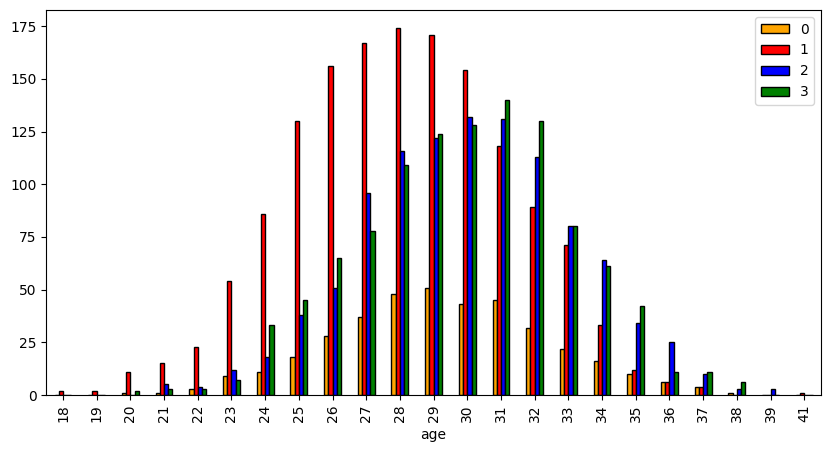

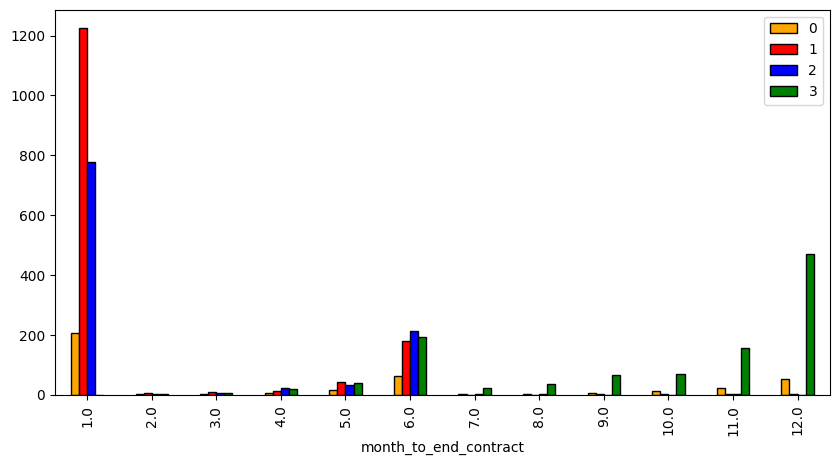

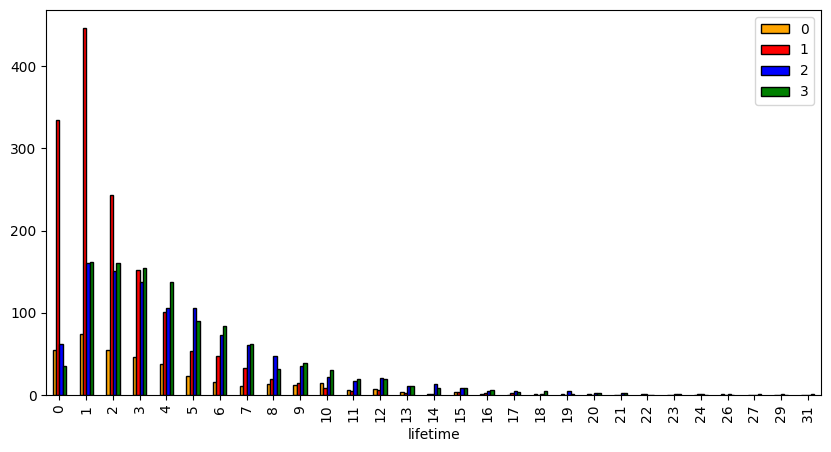

In [34]:
def graphic_per_feature(df, feature):
    handles_cluster = [0, 1, 2, 3]
    cluster0 = df[df['cluster'] == 0].groupby(feature)[feature].count()
    cluster1 = df[df['cluster'] == 1].groupby(feature)[feature].count()
    cluster2 = df[df['cluster'] == 2].groupby(feature)[feature].count()
    cluster3 = df[df['cluster'] == 3].groupby(feature)[feature].count()
    data = pd.concat([cluster0, cluster1, cluster2, cluster3], axis=1)
    data.columns = handles_cluster
    data.plot(kind = 'bar',
              edgecolor = 'black',
              figsize=[10,5],
              color=['orange', 'red', 'blue', 'green'])
    plt.show()
    return

# Se seleccionan las características continuas de los clientes:
columns = ['age', 'month_to_end_contract', 'lifetime']
for x in columns:
    graphic_per_feature(df = df, feature = x)

**Conclusiones:**

* La distribución de la edad es similar para los 4 cluster, con pequeñas diferencias en las medias de los clústeres.

* A la mayoría de clientes de los clústeres **0**, **1** y **3** les resta **1 mes para finalizar el contrato** y a algunos pocos les restan menos de 6 meses para finalizar el contrato, el resto de valores tienen frecuencias muy bajas.

* A la mayoría de clientes del **cluster 2** les restan **6 meses o mas** para finalizar el contrato.

* La mayoría de los clientes de los **4 clústeres** tienen **menos de 8 meses** de haber asistido por primera vez al gimnasio.

Ya que las caraterísticas **'avg_additional_charges_total'**, **'avg_class_frequency_total'** y **'avg_class_frequency_current_month'** tienen decimales flotantes en sus valores, no se logra ver correctamente un gráfico de barras para estas características por lo que podrían tenerse tantas barras como datos hay y la longitud de estas barras serían muy pequeñas; del mismo modo, los histogramas no se pueden ver claramente debido a que unos colores cubren a los otros y no se logran diferenciar claramente los valores de un cluster y otro.

Debido a lo antes mencionado, se catogorizan los valores de estas características para que de esta forma se pueda realizar un gráfico que pueda ser claramente visible cada barra.

In [35]:
# Se define una función para categorizar los valores de las características tipo float:
def categorize_data(data, num_categories):
    min_val = np.min(data)
    max_val = np.max(data)
    category_width = (max_val - min_val) / num_categories
    categories = np.floor((data - min_val) / category_width).astype(int)
    categories = np.clip(categories, 0, num_categories - 1)  # Ensure categories are within bounds
    categories = round(min_val + category_width * (categories + .5), 2)
    return categories

# Se crea una copia de las características del tipo float y de los clústeres:
filtred_df = df[['cluster', 'avg_additional_charges_total', 'avg_class_frequency_total',
                 'avg_class_frequency_current_month']].copy()

# Se agregan las columnas de categorización de los valores de las 3 carataerísticas float:
filtred_df['avg_additional_charges_total_cat'] = categorize_data(filtred_df['avg_additional_charges_total'], 12)
filtred_df['avg_class_frequency_total_bins_cat'] = categorize_data(filtred_df['avg_class_frequency_total'], 12)
filtred_df['avg_class_frequency_current_month_cat'] = categorize_data(filtred_df['avg_class_frequency_current_month'], 12)

**Se crean las gráficas de las carateríticas float:**

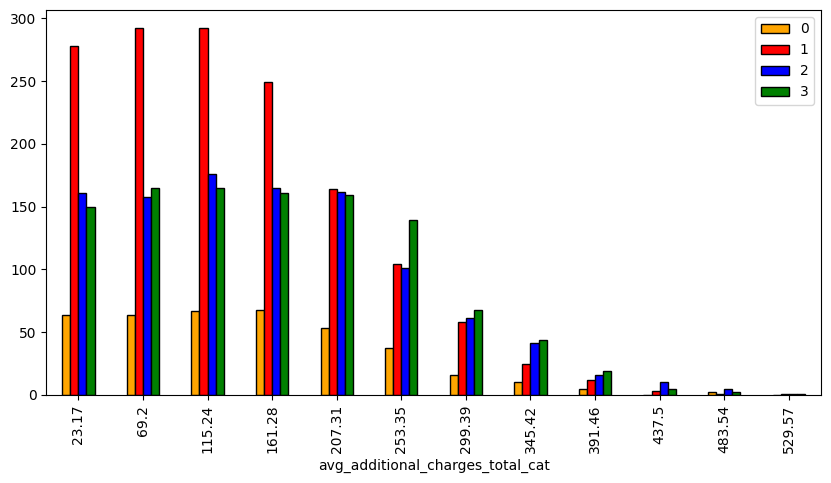

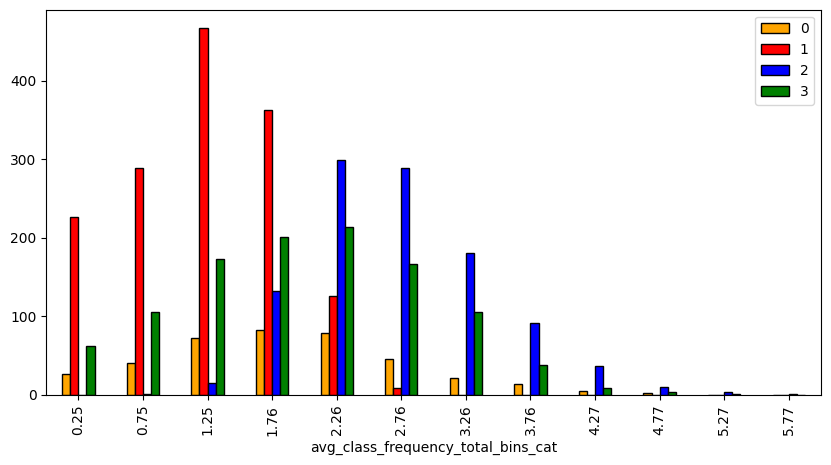

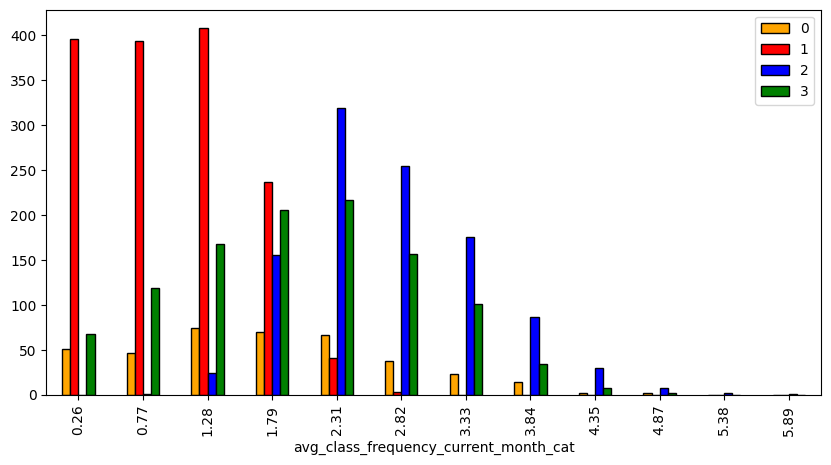

In [36]:
# Se seleccionan las características:
columns = ['avg_additional_charges_total_cat', 'avg_class_frequency_total_bins_cat', 'avg_class_frequency_current_month_cat']

# Se crea un bucle para realizar las gráficas para cada característica:
for x in columns:
    graphic_per_feature(df = filtred_df, feature = x)

**Conclusiones:**

* No se pueden ver diferencias obvias en la distribución del gasto en otros servicios del último mes de los clientes para los diferentes clústeres.

* La frecuencia con la que asisten los clientes para semanalmente en promedio tanto para el último mes como para el del tiempo de todo el historial del cliente es menor en el clúster 1, después en el clúster 0, luego en el clúster 2 y los que parecen acudir con más fecuencia son los clientes del clúster 3.

### Calcula la tasa de cancelación para cada clúster (utiliza el método groupby()). ¿Difieren en términos de tasa de cancelación? ¿Qué grupos son propensos a irse y cuáles son leales?

Aunque ya se realizó y se mostró el cálculo previamente, se vuelve a presentar debido a la solicitud de éste punto.

In [37]:
# Se obtienen los valores medios de las características por clúster
df.groupby(['cluster']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839
1,0.486815,0.759297,0.381339,0.190669,1.0,1.899256,0.292765,28.048005,129.704525,1.805274,2.235294,1.204610,0.951590,0.559838
2,0.544939,0.861873,0.343425,0.205298,1.0,2.403027,0.447493,29.989593,157.358764,2.239357,4.704825,2.724796,2.711132,0.092715
3,0.503711,0.940631,0.777365,0.572356,1.0,10.697588,0.536178,29.912801,161.363032,9.768089,4.730056,1.983884,1.975592,0.029685


**Conclusiones:**
* De forma general, se puede decir que los clientes que tienen más probabilidad de cancelar (clústeres **0** y **1**) son aquellos que realizan menor gasto mensual promedio, que disminuyen significativamente la frecuencia de asistencia semanal en el último mes respecto al promedio de todo el tiempo de vida, los que asisten menos de 2 veces por semana y que tienen menos de 3 meses de vida.

* Los clientes de los clústeres **2** y **3** son más propensos a quedarse.

**Conclusiones generales y recomendaciones:**

* Para el caso de estudio, el aprendizaje supervisado presenta un error que es alto al ser evaluado con los valores de prueba para ambos modelos de aprendizaje.

* Las características evaluadas tienen una correlación muy baja, excepto el promedio de asistencia semanal del último mes y el promedio de asistencia semanal de todo el tiempo de vida del cliente.

* Por su parte, el aprendizaje no supervisado puede identificar diferencias entre grupos de estudio que a simple vista no se pueden ver o que con los modelos de aprendizaje supervisado nos hacen más dificil predecir comportamientos de ciertas variables cuya correlación es tan baja.

* Debido a que los clientes de los clústeres **2** y **3** presentaban valores mayores en las siguientes características, se sugiere:
    * Realizar publicidad orientada a aumentar la cantidad de contratos de 12 meses o en su defecto, contratos de 6 meses.

    * Hacer publicidad para aumentar las ventas de otros productos y servicios.
    
    * Incentivar la asistencia de los clientes en el último mes de sus contratos.
    
Todas estas cosas, además de aumentar los ingresos de la empresa de forma directa, promueven el incremento de los ingresos de la compañia en el mediano plazo ya que pueden incentivar a que el tiempo de vida del cliente sea mayor.